In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import pickle
import datetime
from collections import defaultdict

Data source: <a href ='http://people.uncw.edu/hinese/HAL/HAL%20Web%20Page.htm'>Project HAL </a>

- HAL (Historical American Lynching) is a data collection process
    - Original data sourced from NAACP's Lynching Records ('source' == 1)
    - Additional data comes from 'user' submissions ('source' == 2)


- Lynches are defined as described by the NAACP as meeting these qualifications:

    1) There must be evidence that someone was killed;

    2) The killing must have occurred illegally;

    3) Three or more persons must have taken part in the killing; and

    4) The killers must have claimed to be serving justice or tradition.

In [2]:
def load_plus_del_cols(file_path = 'data/HAL.csv'):
    df = pd.read_csv(file_path)
    print 'df raw shape: {}'.format(df.shape)
    unnamed_cols = []
    for col in df.columns:
        if 'Unnamed' in col:
            unnamed_cols.append(col)
            print '{} has NA vals: {}'.format(col,df[col].isna().sum())
    print 'pre drop shape: {}'.format(df.shape)
    df.drop(unnamed_cols, axis=1, inplace=True)
    print 'post drop shape: {}'.format(df.shape)
    
    na_cols = [
        'Source',
        'Comments',
        '3rd Name',
        'Note',
        '2nd Name',
        'Mob'
    ]

    for na_col in na_cols:
        print '{} has {} na values\n'.format(na_col,df[na_col].isna().sum())
    print 'pre drop shape: {}'.format(df.shape)
    df.drop(na_cols,axis=1,inplace=True)
    print 'post drop shape: {}'.format(df.shape)
    
    return df


def feat_desc(df,feat,quant=0):
    print 'feat: {}'.format(feat)
    na_sum = df[feat].isna().sum()
    na_pct = float(na_sum) / df.shape[0] * 100.
    neg9 = df[df[feat] == -9].shape[0]
    neg99 = df[df[feat] == -99].shape[0]
    unknown_sum = (neg9 + neg99)
    unknown_pct = float(unknown_sum) / df.shape[0] * 100.
    
    print 'na sum: {} and pct: {}'.format(na_sum, na_pct)
    print 'unknown sum: {} and pct: {}'.format(unknown_sum,unknown_pct)
    if quant == 0:
        nunique = df[feat].nunique()
        print 'number unique: {}'.format(nunique)

In [3]:
df = load_plus_del_cols()

df raw shape: (2806, 34)
Unnamed: 13 has NA vals: 2806
Unnamed: 15 has NA vals: 2806
Unnamed: 16 has NA vals: 2806
Unnamed: 17 has NA vals: 2806
Unnamed: 18 has NA vals: 2806
Unnamed: 19 has NA vals: 2806
Unnamed: 20 has NA vals: 2806
Unnamed: 21 has NA vals: 2806
Unnamed: 22 has NA vals: 2806
Unnamed: 23 has NA vals: 2806
Unnamed: 24 has NA vals: 2806
Unnamed: 25 has NA vals: 2806
Unnamed: 26 has NA vals: 2806
Unnamed: 27 has NA vals: 2806
Unnamed: 28 has NA vals: 2806
Unnamed: 29 has NA vals: 2806
Unnamed: 30 has NA vals: 2806
Unnamed: 31 has NA vals: 2806
Unnamed: 32 has NA vals: 2806
pre drop shape: (2806, 34)
post drop shape: (2806, 15)
Source has 2804 na values

Comments has 2803 na values

3rd Name has 2724 na values

Note has 2529 na values

2nd Name has 2017 na values

Mob has 2650 na values

pre drop shape: (2806, 15)
post drop shape: (2806, 9)


In [4]:
df.shape

(2806, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2806 entries, 0 to 2805
Data columns (total 9 columns):
State      2806 non-null object
Year       2806 non-null object
Mo         2805 non-null object
Day        2805 non-null object
Victim     2806 non-null object
County     2806 non-null object
Race       2806 non-null object
Sex        2806 non-null object
Offense    2806 non-null object
dtypes: object(9)
memory usage: 197.4+ KB


In [6]:
df.describe()

,State,Year,Mo,Day,Victim,County,Race,Sex,Offense
count,2806,2806,2805,2805,2806,2806,2806,2806,2806
unique,10,50,13,32,2402,544,4,3,384
top,MS,1892,7,25,Unnamed Negro,Madison,Blk,Male,Murder
freq,538,129,297,112,253,43,2462,2702,863


In [7]:
for col in df.columns:
    feat_desc(df,col)
    print '-'*40

feat: State
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 10
----------------------------------------
feat: Year
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 50
----------------------------------------
feat: Mo
na sum: 1 and pct: 0.0356379187455
unknown sum: 0 and pct: 0.0
number unique: 13
----------------------------------------
feat: Day
na sum: 1 and pct: 0.0356379187455
unknown sum: 0 and pct: 0.0
number unique: 32
----------------------------------------
feat: Victim
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 2402
----------------------------------------
feat: County
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 544
----------------------------------------
feat: Race
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 4
----------------------------------------
feat: Sex
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 3
----------------------------------------
feat: 

#### Initial Observations:
Only NA vals occur for month and day (one obs each)

Sex has 3 possible values, race has 4 vals
Offense has 384 (likely duplicates/similar types, eg Rape vs Attempted Rape, etc)
Observations occur over 50 years (check that, one obs is '1990s')
Data from 10 different states, 544 different counties

2402 unique victim names, likely multiple victims have same name, possibly duplicating observations
    of same incident. Can check names against day/month/year and location data
    
    


#### Description of Data:
10 states

50 years

13 months-- One value for missing likely

1 Day missing (acceptable)

2402 victims, none missing. Suggesting some victims targeted more than once (2806 incidents)

544 counties

4 races

3 sexes-- Male, Female, Unknown

384 unique offenses

Source, Comments, 3rd Name, Note, Mob all 90+ percent missing..
    - 2nd Name has ~ 70% missing
    - All disregarded in this analysis

## Looking into date features:

In [8]:
df['Year'].describe()

count     2806
unique      50
top       1892
freq       129
Name: Year, dtype: object

In [9]:
df['Day'].value_counts()

25    112
21    111
29    106
8     106
14    106
20    105
6     102
28    101
18    101
11     97
13     96
26     94
16     91
22     91
4      90
15     89
2      89
9      89
1      87
23     86
17     86
19     84
10     83
27     82
24     82
12     82
5      79
3      77
7      71
30     66
31     44
.      20
Name: Day, dtype: int64

In [10]:
df['Mo'].value_counts()

7     297
6     277
8     276
5     252
12    248
9     243
10    230
3     223
11    205
4     193
1     187
2     172
.       2
Name: Mo, dtype: int64

In [11]:
# need to change some values for dates:
#     where 'Year' == "1990s" --> change to '1995'
#     where 'Mo' == '.' --> change to median
#     where 'Day' == '.' --> change to median

df['Year'].replace(['1900s'],'1905',inplace=True)
df['Mo'].replace(['.'],6,inplace=True)
df['Day'].replace(['.'],15,inplace=True)

In [12]:
# deleting NA vals:
print 'pre drop shape: {}'.format(df.shape)
df.dropna(how='any',inplace=True)
print 'post drop shape: {} --expecting one row drop'.format(df.shape)

pre drop shape: (2806, 9)
post drop shape: (2805, 9) --expecting one row drop


In [13]:
# changing numeric features data types:
df['Year'] = df['Year'].astype(int)
df['Mo'] = df['Mo'].astype(int)
df['Day'] = df['Day'].astype(int)

## Looking at Offenses (reasons for lynches):

In [14]:
print 'Number of unique offenses: {}'.format(df['Offense'].nunique())

Number of unique offenses: 384


In [15]:
df['Offense'].value_counts()

Murder                           862
Attempted rape                   222
Rape                             218
Murderous assault                 97
Unknown                           83
Arson                             76
Criminal assault (rape)           72
Assault (rape)                    54
Rape & murder                     53
Attempted murder                  51
Attempted assault (rape)          42
Assault                           40
Murder & robbery                  34
Complicity in murder              33
Robbery                           27
Race prejudice                    25
Burglary                          24
Assaulted woman (rape)            23
Theft                             20
Insulted white woman              16
Implicated in murder              15
Accessory to murder               14
Race hatred                       13
Mistaken identity                 13
Outlaw                            12
Assaulted girl (rape)             12
Robbery & arson                   10
E

In [16]:
# many offenses are in similar categories, such as murder and attempted murder and murderous assault 
#     (also rape, attempted rape, assaulted woman)

# will try to reduce into a more generalized offense feature

In [17]:
def generalized_offenses(row):
    offense = row['Offense'].lower()
    if 'murder' in offense:
        return 'murder related'
    elif 'manslaughter' in offense:
        return 'murder related'
    elif 'rape' in offense:
        return 'rape/sexual related'
    elif 'sexual' in offense:
        return 'rape/sexual related'
    elif any(theft in offense for theft in ['theft','steal','robbery','burglary','larceny']):
        return 'theft related'
    elif any(arson in offense for arson in ['arson','incendiarism','burning']):
        return 'arson related'
    elif any(racist in offense for racist in ['prejudice','white woman','race','racial','miscegenation']):
        return 'racsim related'
    elif any(violence in offense for violence in ['assault','assaulted','shot','threat','threats',
                                                 'shooting','altercation','rioting','kill','fighting',
                                                 'dynamiting','quarrelling','terrorism']):
        return 'violence related'
    elif any(sexual in offense for sexual in ['peeping', 'adultery','incest',
                                             "woman's", "girl's",'girls','jilted','flirted',
                                             'woman','women','eloped','rapist','cohabitation','girl']):
        return 'rape/sexual related'
    elif 'unknown' in offense:
        return 'unknown'
    else:
        return offense

In [18]:
df['general_offense'] = df.apply(generalized_offenses,axis=1)
print 'len generalized offenses: {}, len original offenses: {}'.format(
    len(df['general_offense'].value_counts()), len(df['Offense'].value_counts()))

len generalized offenses: 117, len original offenses: 384


In [19]:
# reduced offense feature from 384 values to 117, still could go further but these categories are okay for now

In [20]:
df['general_offense'].value_counts()

murder related                  1265
rape/sexual related              813
violence related                 149
theft related                    121
arson related                    105
racsim related                    89
unknown                           88
mistaken identity                 13
outlaw                            12
testifying                         7
bad character                      5
informer                           5
disorderly conduct                 3
desperado                          3
poisoning mules                    3
refused information                3
angered klan                       2
aided escape                       2
aided in lynching                  2
indecent proposals                 2
poisoned boys                      2
incendiary language                2
jailbreak                          2
preaching mormonism                2
wounded men                        2
fraud                              2
miscegnation                       2
t

In [21]:
# think ok on preprocessing for now, object dtypes can stay that (even tho they are holding strings/should be)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2805 entries, 0 to 2805
Data columns (total 10 columns):
State              2805 non-null object
Year               2805 non-null int64
Mo                 2805 non-null int64
Day                2805 non-null int64
Victim             2805 non-null object
County             2805 non-null object
Race               2805 non-null object
Sex                2805 non-null object
Offense            2805 non-null object
general_offense    2805 non-null object
dtypes: int64(3), object(7)
memory usage: 241.1+ KB


In [23]:
df.head()

,State,Year,Mo,Day,Victim,County,Race,Sex,Offense,general_offense
0,AL,1904,4,30,Gaines Hall,Autauga,Blk,Male,Assaulted woman (rape),rape/sexual related
1,AL,1908,4,5,Walter Clayton,Baldwin,Blk,Male,Rape,rape/sexual related
2,AL,1919,6,15,Frank Foukal,Baldwin,Wht,Male,Murder,murder related
3,AL,1885,10,21,George Ward,Barbour,Blk,Male,Murder,murder related
4,AL,1911,2,12,Iver Peterson,Barbour,Blk,Male,Attempted assault (rape),rape/sexual related


# Initial Plots

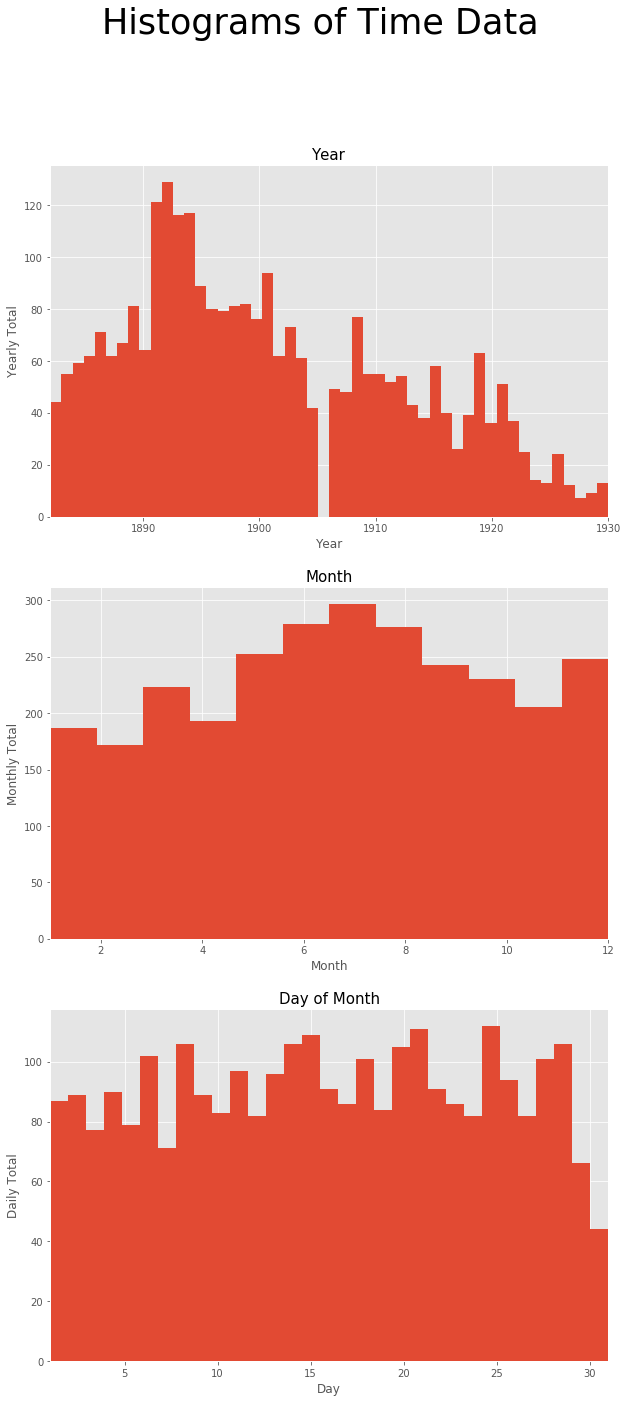

In [24]:
fig, ax = plt.subplots(ncols=1,nrows=3,figsize=(10,22))

plt.suptitle('Histograms of Time Data',size=35)
df['Year'].hist(ax=ax[0],bins=50)
ax[0].set_ylabel('Yearly Total')
ax[0].set_xlabel('Year')
ax[0].set_title('Year',size=15)
ax[0].set_xlim(df['Year'].min(), df['Year'].max())
df['Mo'].hist(ax=ax[1],bins=12)
ax[1].set_ylabel('Monthly Total')
ax[1].set_xlabel('Month')
ax[1].set_title('Month',size=15)
ax[1].set_xlim(df['Mo'].min(), df['Mo'].max())
df['Day'].hist(ax=ax[2],bins=31)
ax[2].set_ylabel('Daily Total')
ax[2].set_xlabel('Day')
ax[2].set_title('Day of Month',size=15)
ax[2].set_xlim(df['Day'].min(), df['Day'].max())


plt.show()


Looks like no incidents were reported/occurred in 1905.
Big spike in incidents in early-mid 1890s, afterwhich there is steady decline. 
    - could be some social/economic/other factors contributing to this
    
Monthly occurrences are pretty steady, peak in middle months and slightly in December.
    - July highest, June/Aug next
    - Similar to present day rise in crime during summer months?
    
Day of month data looks to be not patterned, lowest incidents occur on 31 then 30th, likely due to less months containing these days.

### State plotting

In [25]:
df['State'].value_counts()

MS    538
GA    458
LA    360
AL    300
FL    250
AR    241
TN    214
KY    191
SC    156
NC     97
Name: State, dtype: int64

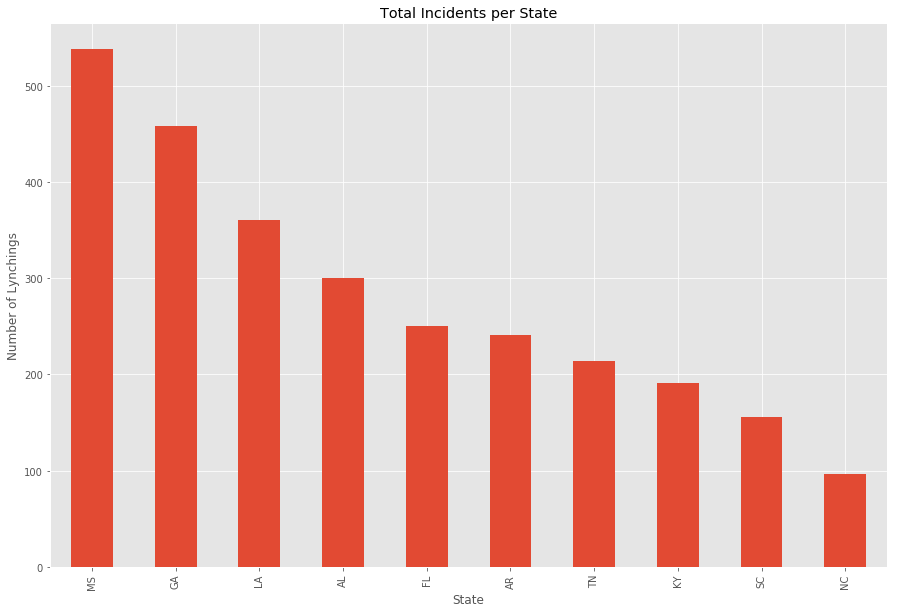

In [26]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
df['State'].value_counts().plot.bar(ax=ax)
ax.set_title('Total Incidents per State')
ax.set_ylabel('Number of Lynchings')
ax.set_xlabel('State')
plt.show()

Mississippi (~20%) is the state with the most recorded incidents in this dataset, followed by Georgia (~17%).

### Sex and Race plots

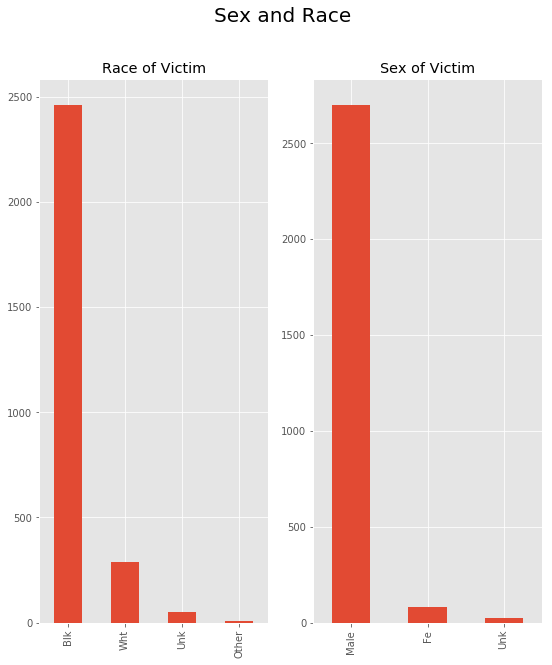

In [27]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(9,10))

plt.suptitle('Sex and Race',size=20)
df['Race'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Race of Victim')
df['Sex'].value_counts().plot.bar(ax=ax[1])
ax[1].set_title('Sex of Victim')
plt.show()

Vast majority of victims are black males. Victim age not included in data but would be interesting to see.

Some victims recorded as 'unknown' for either both sex or race or both. Hard to believe and is potentially evidence of limitations of dataset.

In [28]:
print 'Number of incidents where race is unknown: {}'.format(df.loc[df['Race'] == 'Unk'].shape[0])
print 'Number of incidents where sex is unknown: {}'.format(df.loc[df['Sex'] == 'Unk'].shape[0])
print 'Number of incidents where BOTH race and sex are unknown: {}'.format(df.loc[(df['Sex'] == 'Unk') & (df['Race'] == 'Unk')].shape[0])


Number of incidents where race is unknown: 50
Number of incidents where sex is unknown: 25
Number of incidents where BOTH race and sex are unknown: 1


### plotting yearly incidents with additional key events

In [29]:
# adding in selected key events-
significant_dates = {}
significant_dates['1889'] = 'Anti-Lynching Bureau Founded'
significant_dates['1896'] = 'Plessy v. Ferguson'
significant_dates['1909'] = 'US v. Shipp'
significant_dates['1915'] = 'Second KKK founding'
significant_dates['1917'] = 'Buchanan v. Warley'
significant_dates['1919'] = 'NAACP publishes "Thirty Years of Lynching in US"'
significant_dates['1921'] = 'Tulsa, OK Race Riots'
significant_dates['1922'] = 'US Senate defeats anti-lynching leglislation'
significant_dates['1923'] = 'Whites attack Rosewood, FL black community'

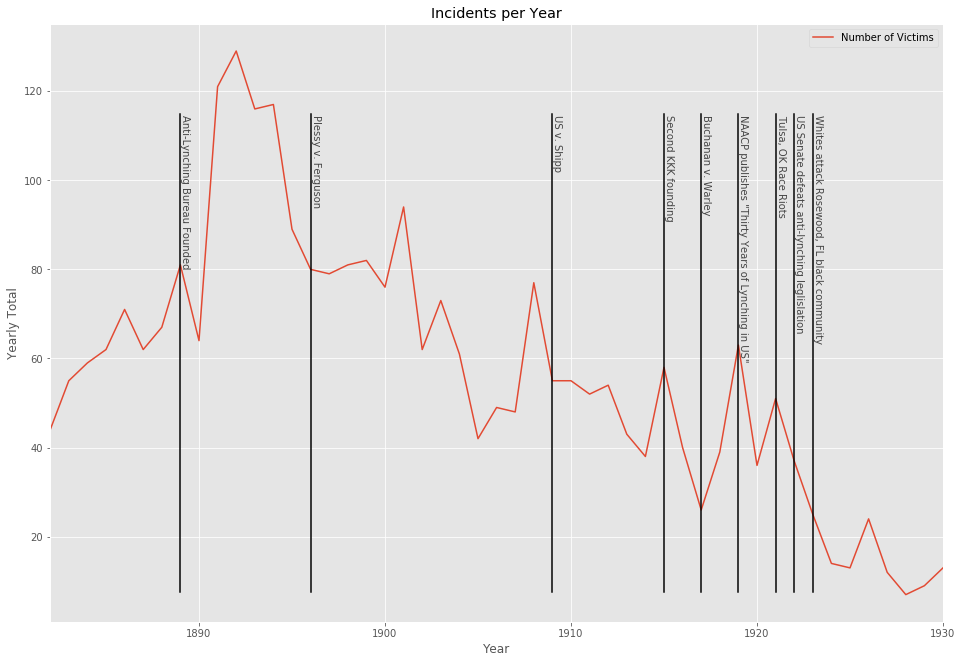

In [30]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(16,11))
# plt.title('Yearly Lynching Incidents with Selected Events')
df.groupby('Year')['Victim'].count().plot(ax=ax,label='Number of Victims')
ax.set_title('Incidents per Year')
ax.set_ylabel('Yearly Total')
# ax.axvline(x=1903,color='black',ymax=10,label='HIE')
text_drop = 0
for key_year, val_desc in significant_dates.items():
    ax.axvline(x=int(key_year),color='black',ymax=.85,ymin=.05)
    ax.text(x=int(key_year),s=val_desc,y=113,alpha=.7,rotation=270)
    text_drop += 10
#     ax.text(val_desc)
ax.legend()

# axes[1,2].axvline(x=base_desc['50%'],color='r')
plt.show()




Yearly incidents peaked in the early 1890s and have generally steadily declined until the last year recorded in this dataset (1930). Although this chart is plotting total incidents, it would be beneficial to get incidents per capita for each state (number of incidents per 100,000 residents). 

In the Plessy v Ferguson case, racial segregation was upheld as long as equal treatment was provided after Homer Plessy violated Louisiana's Separate Car Act of 1890. The 7-1 verdict in favor of supporting "separate but equal" state laws ruled that Louisiana didn't violate the fourtenteenth amendment (citizenship to all persons born or naturalized in the US, federal representatives alloted equally among citizens). Source: https://en.wikipedia.org/wiki/Plessy_v._Ferguson

In the Supreme Court ruling in US v Shipp (the only Supreme Court conducted criminal trial to date), Sheriff Shipp and several others were convicted of contempt of court and sentenced to token jail sentences after allegedly allowing a mob to enter the jailhouse where an inmate, Ed Johnson, was being held, leading to Mr. Johnson's eventual lynching. Mr. Johnson was a black man being held for the rape of a white woman in the process of appealing on the grounds of his constitutional rights were violated during the trial (denial of rights of counsel and an unrepresentative jury). Source: https://en.wikipedia.org/wiki/United_States_v._Shipp

In Buchanan v. Warley the Supreme Court overturned the Kentucky Court's ruling that prohibited sales of property to blacks in majority white neighborhoods. The ruling stated that the prohibition of sales violated the fourteenth amendment's freedom of contract right. Source: https://en.wikipedia.org/wiki/Buchanan_v._Warley

In late May and early June, 1921 the black community in Tulsa, OK were attacked. The riots were started after a black man, Dick Rowland, was arrested for allegedly assualting a white woman and mobs formed to lynch the perpetrator. A black counter mob assembled and went to the jailhouse to protect Rowland and a firefight ensued between the two mobs resulting in 10 white and 2 black dead. Afterwards the black community was attacked, including by aircraft firebombing resulting in 10,000 left homeless, damages upwards of $2 million, and between 36 and 300 dead. No monetary compensation was awarded to the black community for damages caused by whites. Source: https://en.wikipedia.org/wiki/Tulsa_race_massacre

The Rosewood, FL massacre occurred in early January, 1923 amid rising lynchings of Florida black men. Whites burned nearly every building in town and killed between 8 and 150 people. The massacre wasn't widely reported when it happened but has since received coverage and memorials. The event effectively ended the town of Rosewood as survivors fled and nobody moved back. Similar to the Tulsa massacre, no monetary compensation was given for damages caused to the black community. Source: https://en.wikipedia.org/wiki/Rosewood_massacre

### State incident per capita

In [31]:
## adding in population data:
## data found on wikipedia: 
#     https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_historical_population#1870%E2%80%931950,_census_data

total1_df = pd.read_csv('data/pop_total1.csv')
total2_df = pd.read_csv('data/pop_total2.csv')
slavery_df = pd.read_csv('data/pop_slavery.csv')

# modifying col names
total1_df.columns = total1_df.columns.str.replace("\n","")
total2_df.columns = total2_df.columns.str.replace("\n","")
slavery_df.columns = slavery_df.columns.str.replace("\n","")

total1_df.set_index('Name',inplace=True)
total2_df.set_index('Name',inplace=True)
slavery_df.set_index('Name',inplace=True)

pop_total_df = pd.concat([total1_df,total2_df],axis=1)

/home/joey/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [32]:
## combining both population dataframes, deleting duplicate columns 
pop_dfs = [pop_total_df, slavery_df]
for pop_df in pop_dfs:
    print 'pre deleting shape of pop total: {}'.format(pop_df.shape)
    for col in pop_df.columns:
        if 'Unnamed' in col:
            try:
                print 'deleting coL: {}'.format(col)
                pop_df.drop([col],axis=1,inplace=True)
            except Exception as ex:
                print 'error --> {}'.format(ex)
    print 'post deleting shape of pop total: {}'.format(pop_df.shape)

pre deleting shape of pop total: (60, 20)
deleting coL: Unnamed: 0
deleting coL: Unnamed: 0
error --> "['Unnamed: 0'] not found in axis"
post deleting shape of pop total: (60, 18)
pre deleting shape of pop total: (43, 9)
deleting coL: Unnamed: 0
post deleting shape of pop total: (43, 8)


#### plotting state populations pre slavery and per capita incidents by year and gathering meta stats on each state for comparison and analysis

In [33]:
## state_name_dict to be used to match state abbreviations (HAL df) to state full names (population dfs)
state_name_dict = {}
state_name_dict['MS'] = 'Mississippi'
state_name_dict['GA'] = 'Georgia'
state_name_dict['LA'] = 'Louisiana'
state_name_dict['AL'] = 'Alabama'
state_name_dict['FL'] = 'Florida'
state_name_dict['AR'] = 'Arkansas'
state_name_dict['TN'] = 'Tennessee'
state_name_dict['KY'] = 'Kentucky'
state_name_dict['SC'] = 'South Carolina'
state_name_dict['NC'] = 'North Carolina'

/home/joey/anaconda2/envs/py27/lib/python2.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
/home/joey/anaconda2/envs/py27/lib/python2.7/site-packages/pandas/core/generic.py:3783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(obj)


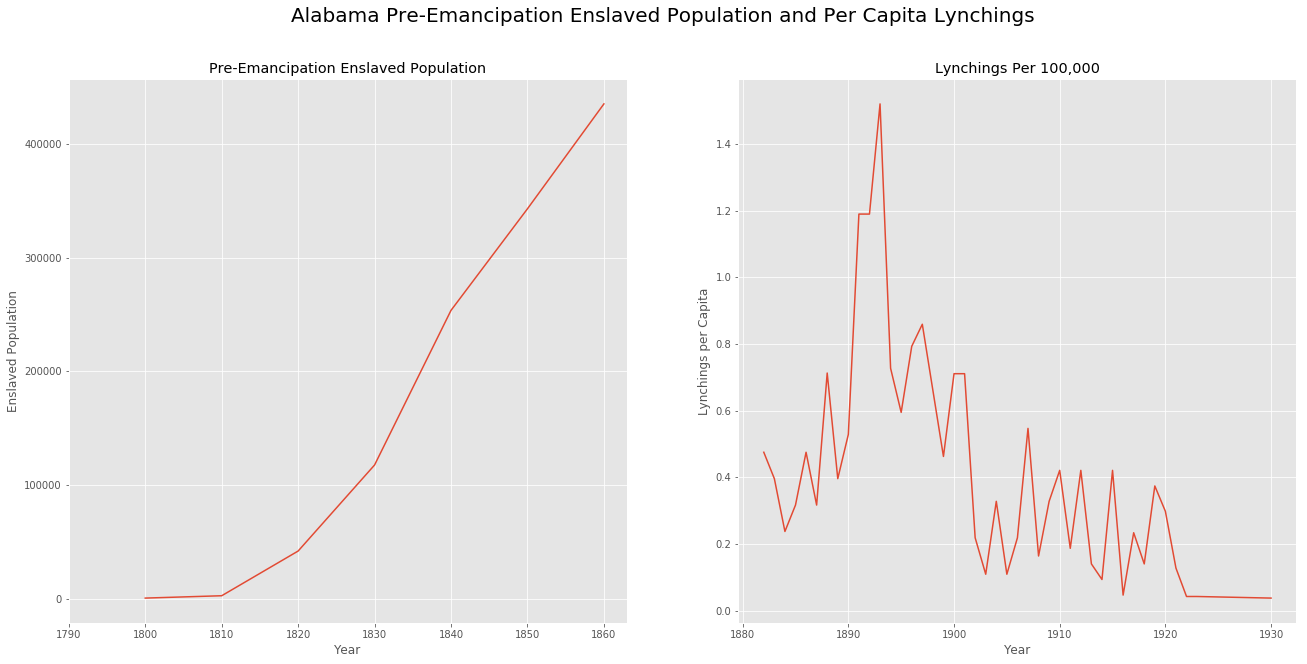

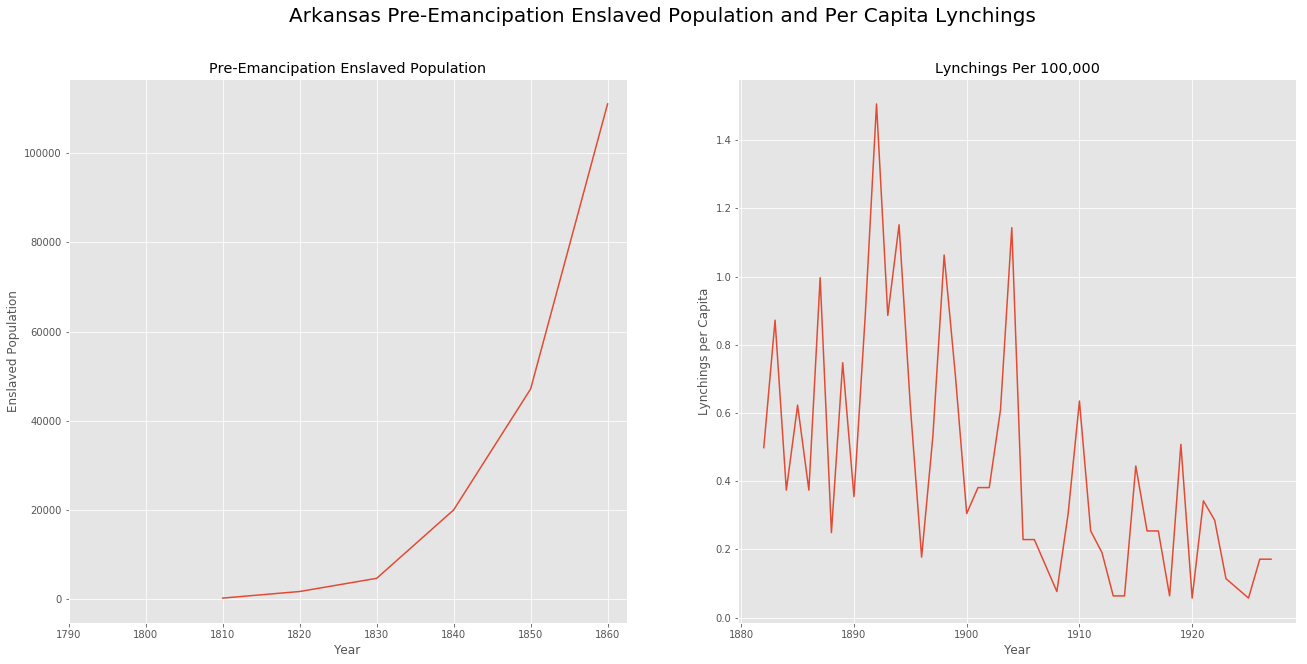

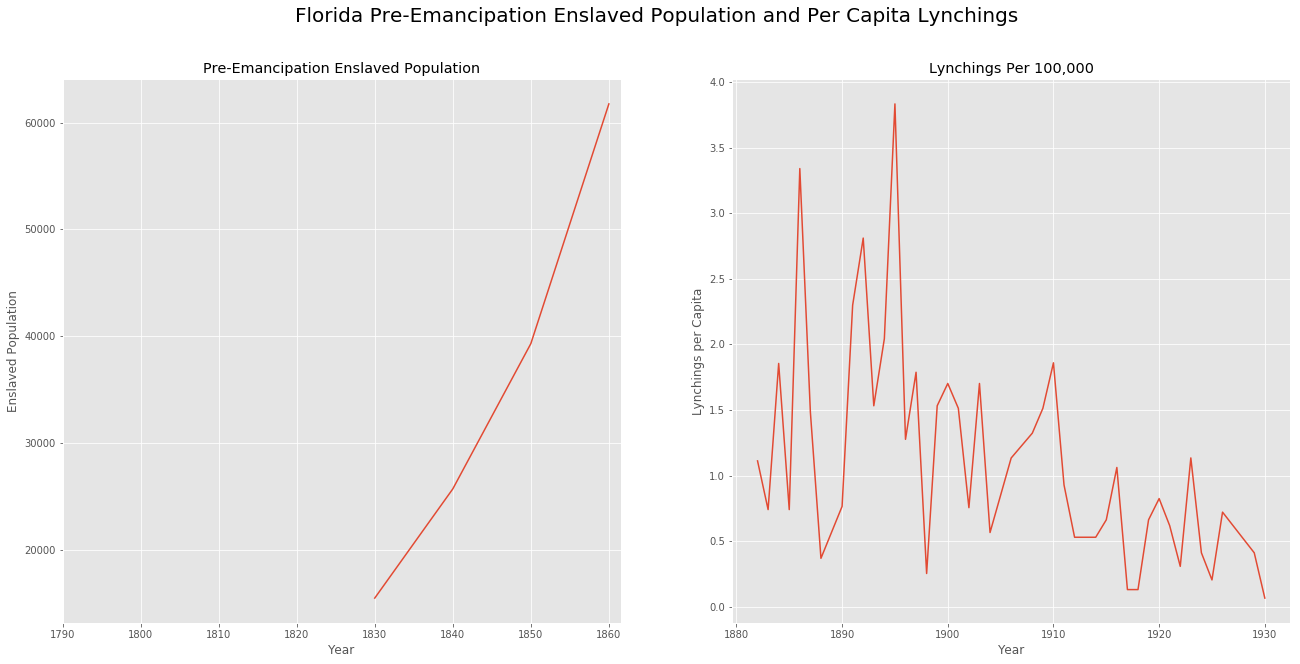

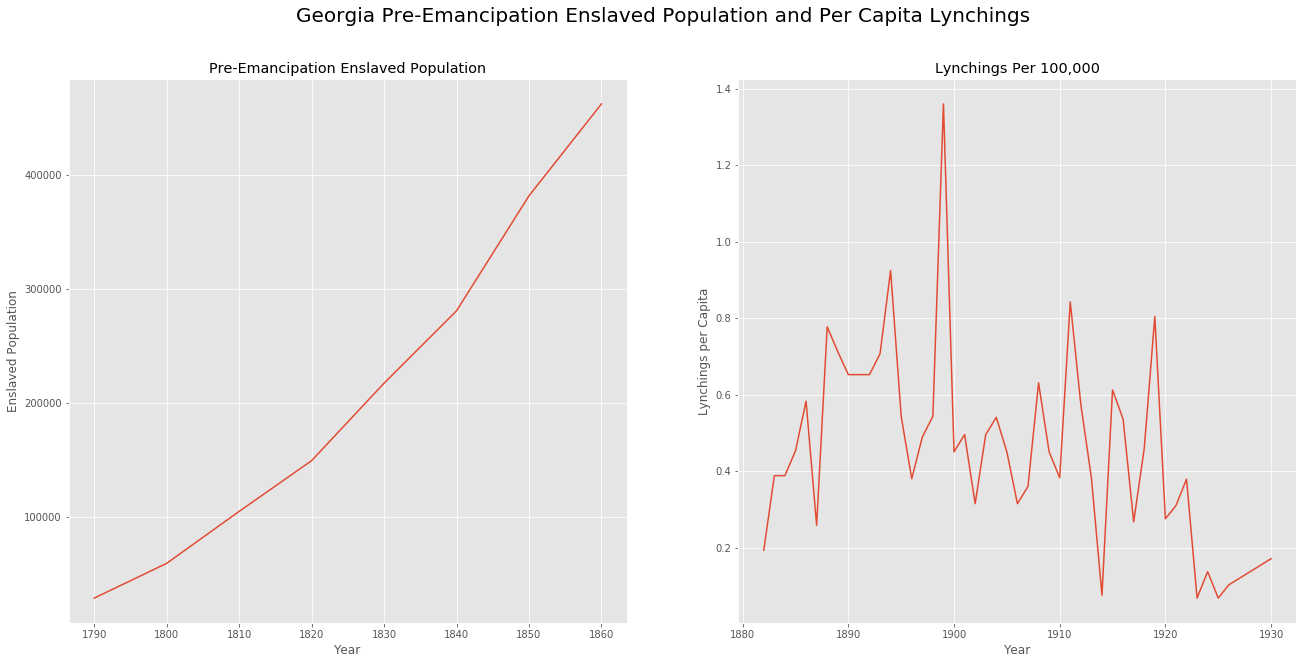

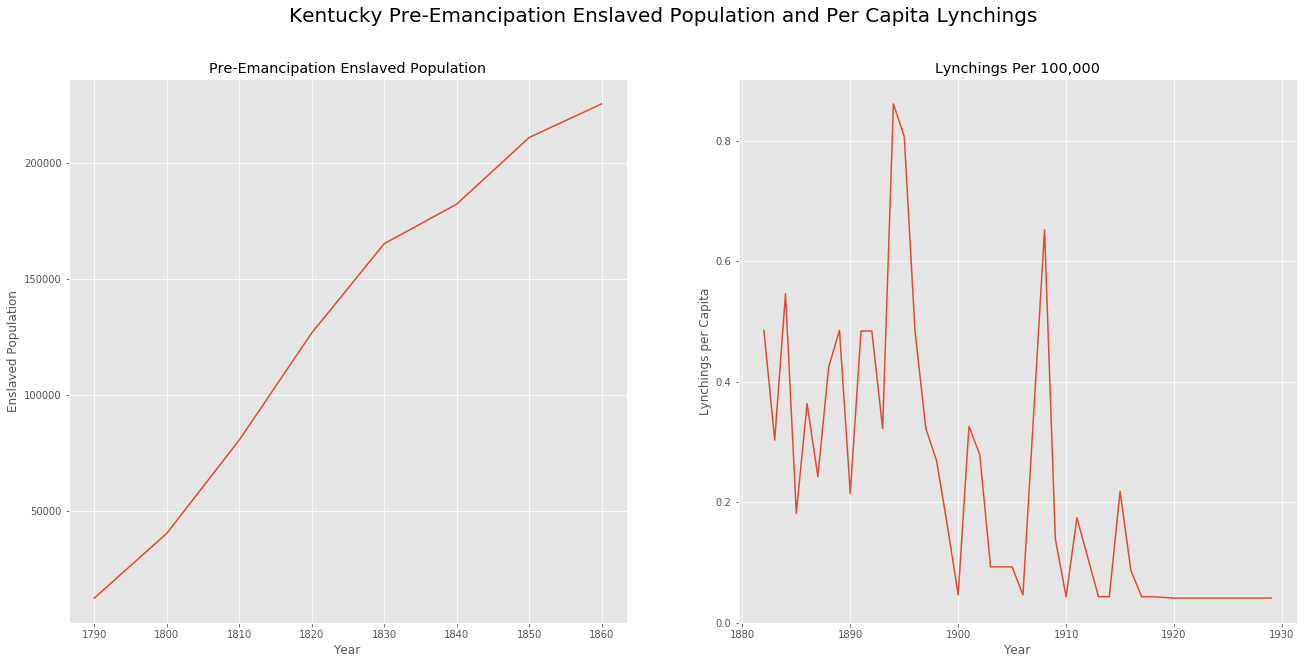

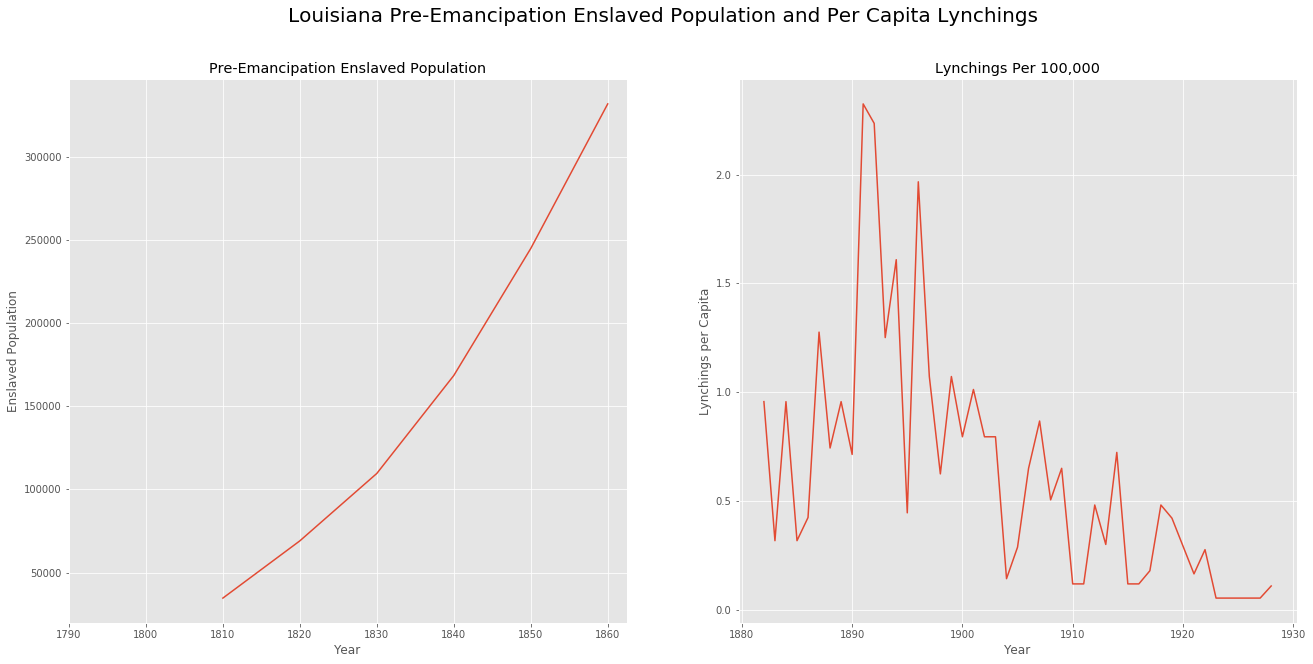

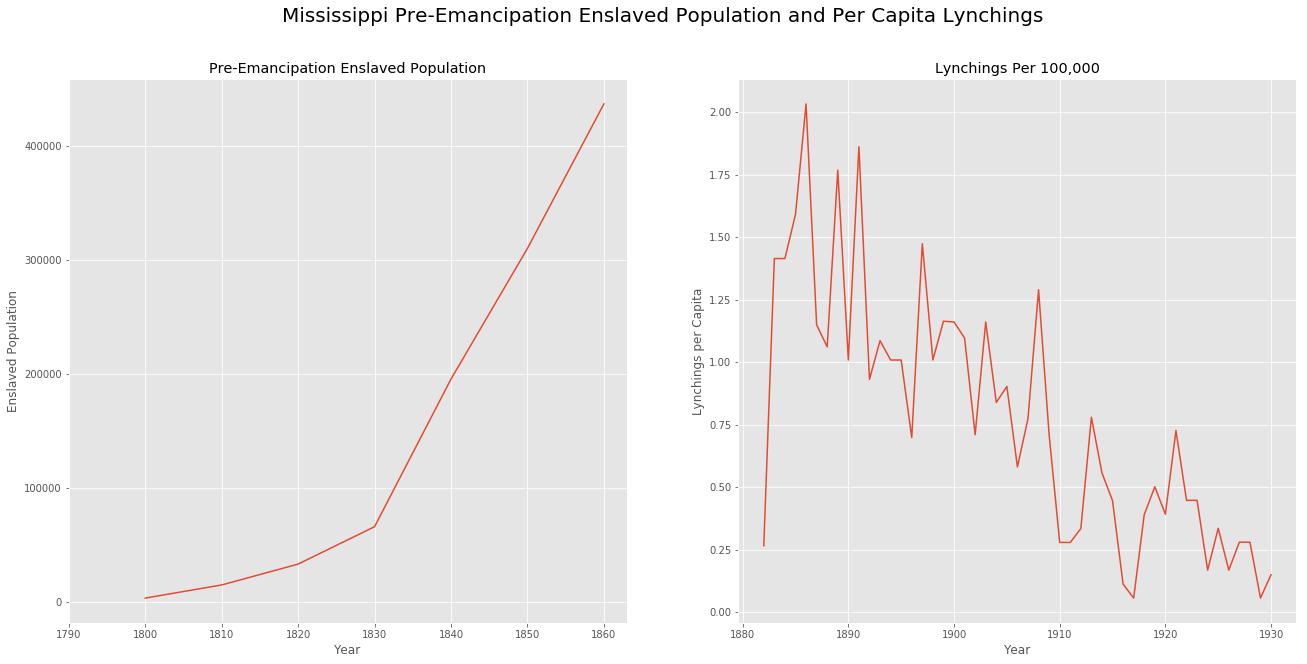

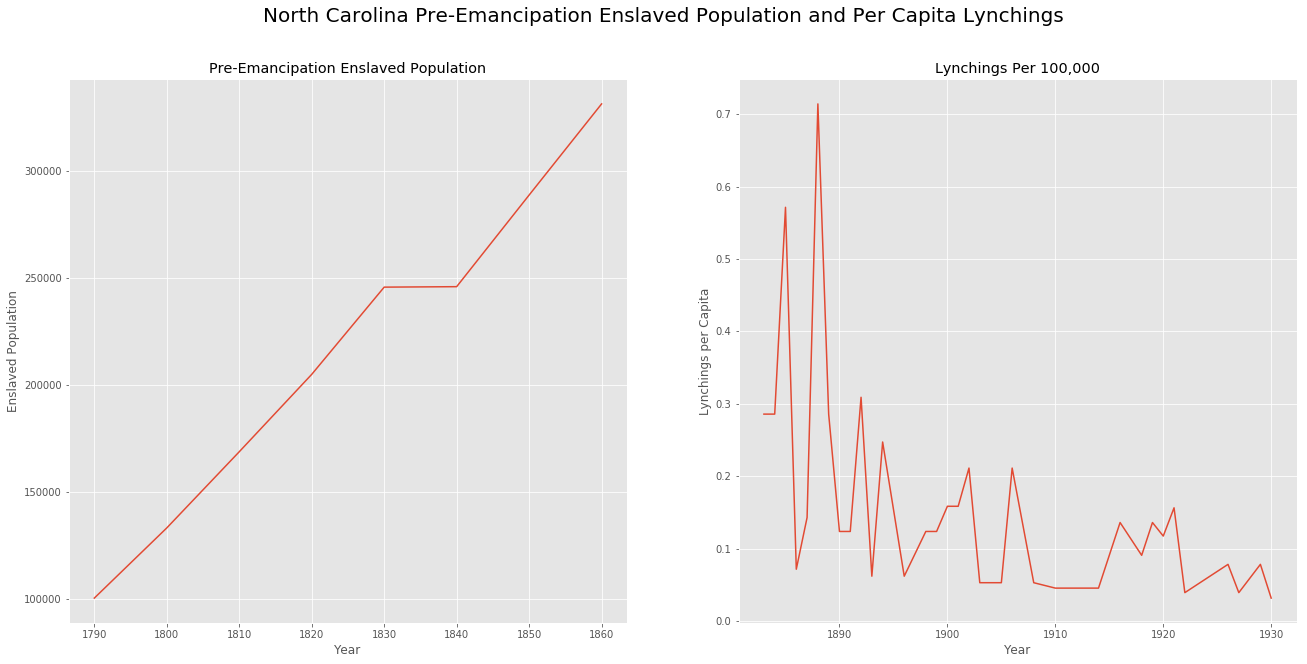

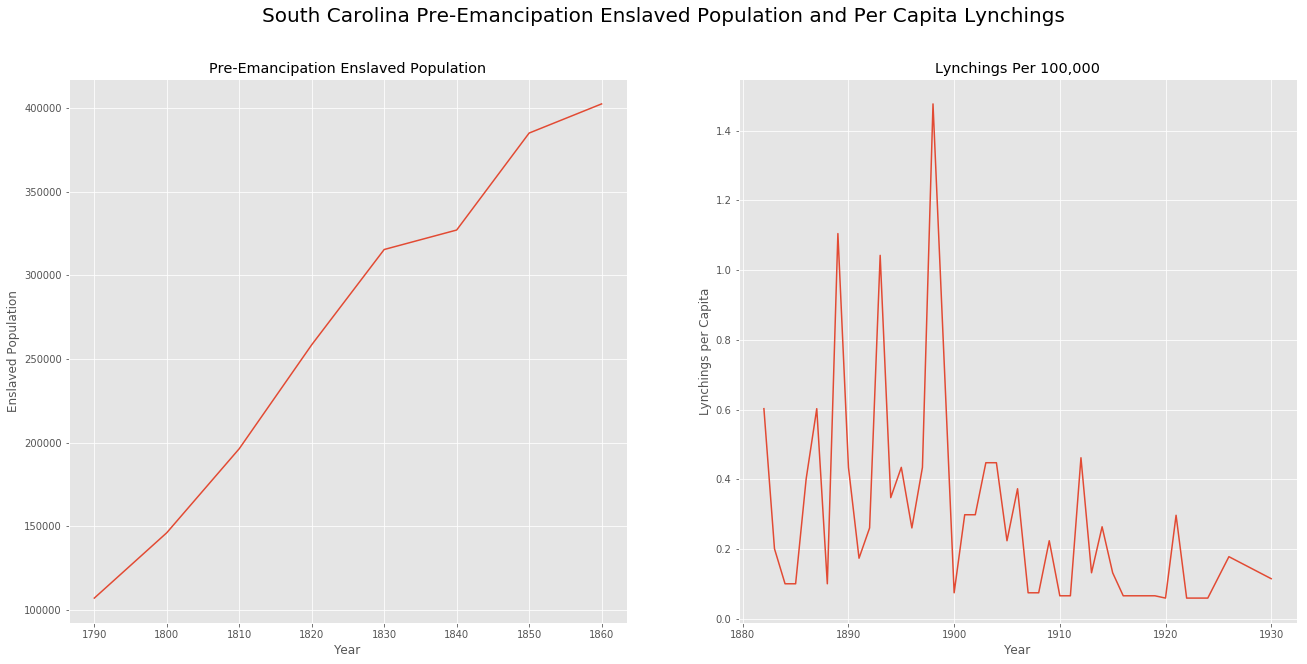

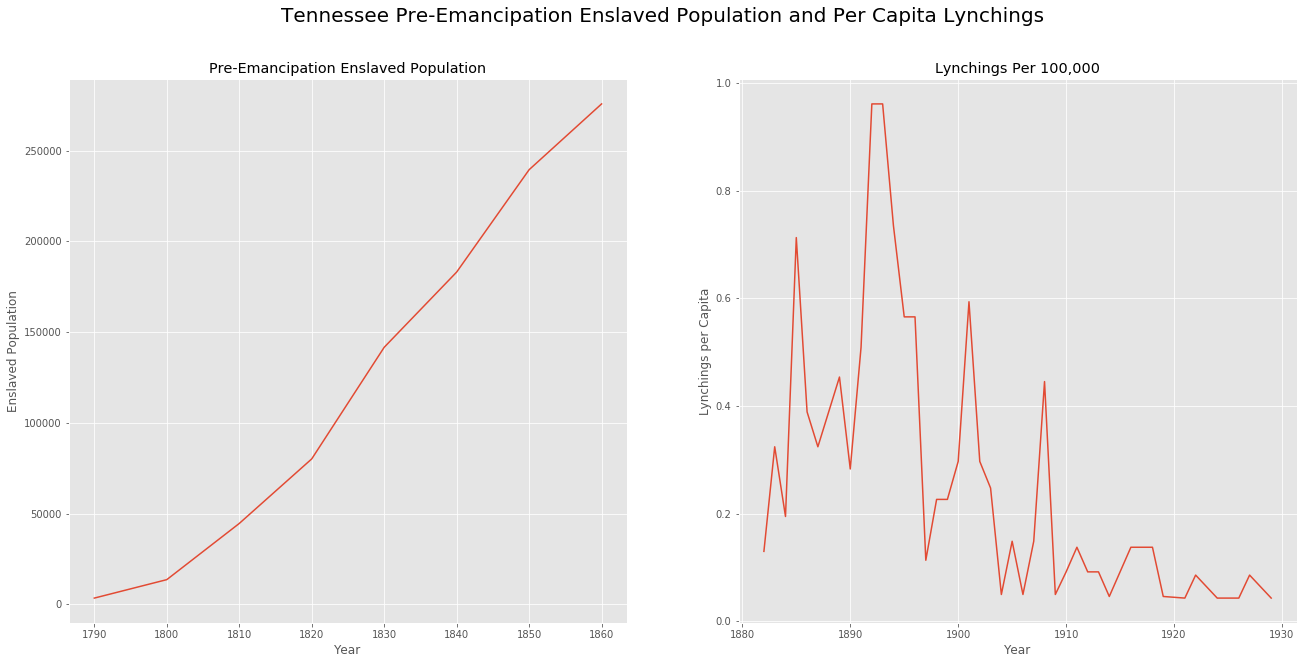

In [34]:
state_groups = df.groupby('State') # grouping by states
state_meta_stats = {}
for name, group in state_groups:
    state_stats = {}
#     print 'state abbr: {} and name: {} ... shape: {}'.format(name,state_name_dict[name],group.shape)
    yearly_incidents = group.groupby('Year').agg({'Victim':{'incident_count':'count'}})
    yearly_incidents.columns = yearly_incidents.columns.droplevel()
    state_pop = pop_total_df.loc[state_name_dict[name]]
    admitted_year = int(state_pop['Admitted[note 2]'])
#     print admitted_year
    state_pop.drop('Admitted[note 2]',inplace=True)
#     print 'state incident df shape: {} ... state pop shape: {}'.format(yearly_incidents.shape, state_pop.shape)
    state_pop.index = state_pop.index.astype(int)
    state_pop.rename('{}_pop'.format(name),inplace=True)
    per_pop_df = pd.concat([yearly_incidents,state_pop],axis=1)
    per_pop_df['{}_pop'.format(name)].fillna(method='ffill',inplace=True)
    per_pop_df.dropna(axis=0,inplace=True)
    per_pop_df['{}_pop'.format(name)] = per_pop_df['{}_pop'.format(name)].astype(float)
    per_pop_df['incident_count'] = per_pop_df['incident_count'].astype(float)
    per_pop_df['lynchings_per_100k'] = per_pop_df['incident_count'] / per_pop_df['{}_pop'.format(name)] * 100000.
    
    fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(22,10))
    plt.suptitle('{} Pre-Emancipation Enslaved Population and Per Capita Lynchings'.format(state_name_dict[name]),
                 size=20)
    axes[0].plot(slavery_df.loc[state_name_dict[name]])
    axes[0].set_xticks(slavery_df.loc[state_name_dict[name]].index)
    axes[0].set_title('Pre-Emancipation Enslaved Population')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Enslaved Population')
    
    axes[1].plot(per_pop_df['lynchings_per_100k'])
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Lynchings per Capita')
    axes[1].set_title('Lynchings Per 100,000')
    plt.show()
    
    
    ############################################################
    ## state meta stats
    per_black = float(group[group['Race'] == 'Blk'].shape[0]) / group.shape[0] * 100.
    per_male = float(group[group['Sex'] == 'Male'].shape[0]) / group.shape[0] * 100.
    top_county_name = group['County'].value_counts().index[0]
    top_county_indidents = group[group['County'] == top_county_name].shape[0]
#     print 'top county: {} and incdients: {}'.format(top_county_name,top_county_indidents)
    num_counties = group['County'].nunique()
    top_offense = group['general_offense'].value_counts().index[0]
    top_offense_count = group[group['general_offense'] == top_offense].shape[0]
    max_per_cap_lynchings = per_pop_df['lynchings_per_100k'].max()
    median_per_cap_lynchings = per_pop_df['lynchings_per_100k'].median()
    max_per_cap_years = per_pop_df.loc[per_pop_df['lynchings_per_100k'] == per_pop_df['lynchings_per_100k'].max()].index
    max_per_cap_years =  [int(max_per_cap_year) for max_per_cap_year in max_per_cap_years]
#     print 'max cap years len: {} .... and max year(s): {}'.format(len(max_per_cap_years),max_per_cap_years) 
#     print 'type max cap years: {}'.format(type(max_per_cap_years))
#     print 'percent black: {} and percent male: {}'.format(per_black, per_male)
    state_stats['admitted_year'] = admitted_year
    state_stats['percent_black'] = per_black
    state_stats['percent_male'] = per_male
    state_stats['top_county'] = (top_county_name, top_county_indidents)
    state_stats['number_of_counties'] = num_counties
    state_stats['top_offense'] = (top_offense, top_offense_count)
    state_stats['median_per_cap_lynchings'] = median_per_cap_lynchings
    state_stats['max_per_cap_lynchings'] = max_per_cap_lynchings
    state_stats['max_per_cap_lynchings_year'] = max_per_cap_years
    state_stats['median_enslaved_pop'] = slavery_df.loc[state_name_dict[name]].median()
    state_stats['max_enslaved_pop'] = slavery_df.loc[state_name_dict[name]].max()
    state_stats['total_incidents'] = group.shape[0]
    state_stats['number_of_years'] = group['Year'].nunique()
    state_stats['years_no_incidents'] = set([year for year in df['Year'] if year not in group['Year'].value_counts().index])
    # adding state stats dict to state_meta_stats dict, key == state name
    state_meta_stats[state_name_dict[name]] = state_stats
    # meta stats (like gtd) per state
#         print type(state_pop)
        

#     print '-'*40

## Chart findings:

All ten states had peak enslaved populations as of the latest year available (1860). The ten states in this data set are all part of the 'cotton belt' which is where slavery thrived the most and was most needed. Nine of these states were included in the confederacy (Kentucky was condsidered a 'Border state'). 

Most states peaked in the late 1880s or early 1890s for per capita lynchings. In the future it would be best to include the proportion of black people in the population data to see if the changes in black residents is a reason for the general declining of per capita lynchings (especially after ~1910).


In [35]:
state_name_dict

{'AL': 'Alabama',
 'AR': 'Arkansas',
 'FL': 'Florida',
 'GA': 'Georgia',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'MS': 'Mississippi',
 'NC': 'North Carolina',
 'SC': 'South Carolina',
 'TN': 'Tennessee'}

## Results found:


In [36]:
years_absent_count = defaultdict(int) # counting number of years no data reported for each state


for k, v in state_meta_stats.items():
    print 'County/incident data from {}:'.format(k)
    print "\t{} county in {} has the most incidents in the state with {} out of {} total incidents ({}) occurring in {} years".\
    format(v['top_county'][0].strip(), k, v['top_county'][1],
           v['total_incidents'],round(float(v['top_county'][1]) / float(v['total_incidents']) * 100.,3),
           v['number_of_years'])
    print 'Race/sex data from {}:'.format(k)
    print '\t{:.3} black, {:.3} percent male'.format(v['percent_black'], v['percent_male'])
    print 'Offense data from {}:'.format(k)
    print '\tThe top offense in {} was {} with {} incidents ({:.3} %)'.format(k,v['top_offense'][0],
                                                                        v['top_offense'][1],
                                                                        float(v['top_offense'][1]) / v['total_incidents'] * 100.)
    print 'Per Capital Data for {}:'.format(k)
    print "\tMaximum per capita lynchings {} occurred in {}. {}'s median per capita lynchings: {}".format(
        v['max_per_cap_lynchings_year'], v['max_per_cap_lynchings'],k,v['median_per_cap_lynchings'])

    for year in v['years_no_incidents']:
        years_absent_count[year] += 1
    print '-'*44

County/incident data from Mississippi:
	Yazoo county in Mississippi has the most incidents in the state with 21 out of 538 total incidents (3.903) occurring in 49 years
Race/sex data from Mississippi:
	94.6 black, 95.7 percent male
Offense data from Mississippi:
	The top offense in Mississippi was murder related with 246 incidents (45.7 %)
Per Capital Data for Mississippi:
	Maximum per capita lynchings [1886] occurred in 2.03252571366. Mississippi's median per capita lynchings: 0.726006328541
--------------------------------------------
County/incident data from Georgia:
	Decatur county in Georgia has the most incidents in the state with 13 out of 458 total incidents (2.838) occurring in 46 years
Race/sex data from Georgia:
	95.0 black, 96.5 percent male
Offense data from Georgia:
	The top offense in Georgia was murder related with 187 incidents (40.8 %)
Per Capital Data for Georgia:
	Maximum per capita lynchings [1899] occurred in 1.36065306993. Georgia's median per capita lynchings: 

### Number of states reporting no incidents per year:

In [37]:
sorted(years_absent_count.items(), key = lambda item: item[1])[::-1]#[:3]

[(1928, 8),
 (1929, 5),
 (1927, 5),
 (1930, 4),
 (1925, 4),
 (1924, 4),
 (1923, 4),
 (1907, 3),
 (1912, 2),
 (1920, 2),
 (1919, 1),
 (1917, 1),
 (1911, 1),
 (1909, 1),
 (1905, 1),
 (1899, 1),
 (1897, 1),
 (1895, 1),
 (1889, 1),
 (1882, 1),
 (1926, 1),
 (1922, 1)]

In 1928 only two states reported lynches, 1929 and 1927 half the states reported lynches, 1923-1925 4 states didn't report any incidents. Interesting to note that these years are all during the 1920s and toward the end of years available in this data set (1930 is the last year in this data).

In [38]:
comparisons = ['total_incidents','percent_black','percent_male',
              'max_per_cap_lynchings','median_per_cap_lynchings',
               'number_of_years','years_no_incidents', 'total_incidents',
              'median_enslaved_pop','max_enslaved_pop']
for comparison in comparisons:
#     print comparison
    comparison_list = []
    for k, v in state_meta_stats.items():
#         print k
#         try:
        comparison_list.append((k,v[comparison]))
#         except Exception as ex:
#             comparison_list.append((k,0))
#     print comparison_list
#     print sorted(comparison_list,key=lambda x: x[1])[:-2:-1]
    print '{} leads {} with {}'.format(sorted(comparison_list,key=lambda x: x[1])[::-1][0][0],
                                       comparison, sorted(comparison_list,key=lambda x: x[1])[::-1][0][1])
    
    print '-'*30

Mississippi leads total_incidents with 538
------------------------------
Georgia leads percent_black with 94.9781659389
------------------------------
Arkansas leads percent_male with 97.9253112033
------------------------------
Florida leads max_per_cap_lynchings with 3.83218112421
------------------------------
Florida leads median_per_cap_lynchings with 0.87806534009
------------------------------
Mississippi leads number_of_years with 49
------------------------------
Louisiana leads years_no_incidents with set([1920, 1929, 1930, 1924])
------------------------------
Mississippi leads total_incidents with 538
------------------------------
South Carolina leads median_enslaved_pop with 286938.0
------------------------------
Georgia leads max_enslaved_pop with 462198.0
------------------------------
